In [144]:
import rebound
import reboundx
import numpy as np
import scipy
from scipy import signal

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

In [145]:
##############
# Read two files that contain orbital parameters for both regular and irregular moons
##############

irreg_data = np.empty((55,10))
with open("irreg_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        irreg_data[i,:] = row
        
reg_data = np.empty((8,14))
with open("regular_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        reg_data[i,:] = row

radeg = np.pi/180

#############
# Below, we define functions that draw from those files to add moons to the system.
#############

def add_moons(sim, moons):
    for i in range(moons):
        rad = reg_data[i,0]*6.68459e-9
        ecc = reg_data[i,1]
        w = reg_data[i,2]*radeg
        incl = reg_data[i,4]*radeg
        node = reg_data[i,5]*radeg
        mass = reg_data[i,7]/(1.989e30)
        
        sim.add(m=mass, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

def add_irregs(sim, moons):
    for i in range(moons):
        rad = irreg_data[i,0]*6.68459e-9
        ecc = irreg_data[i,1]
        w = irreg_data[i,2]*radeg
        incl = irreg_data[i,4]*radeg
        node = irreg_data[i,5]*radeg
        
        sim.add(m=0, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

##############
# We also want to play around with some other randomly-generated, massless objects. Below,
# we define functions to add random objects around Jupiter's hill radius and in the L4 Trojan cloud
##############

def add_hillies(sim, num):
    a_rand = np.random.randint(7,9,size=num)
    a_rand = 1/a_rand
    e_rand = np.random.randint(2,10,size=num)
    e_rand = 1/e_rand
    w_rand = np.random.randint(0,360,size=num)*radeg
    half = int(num/2)
    i_rand1 = np.random.randint(0,30,size=half+1)*radeg
    i_rand2 = np.random.randint(150,180,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    node_rand = np.random.randint(0,360,size=num)*radeg
    
    names = ['hill1', 'hill2', 'hill3', 'hill4']
    
    for i in range(num):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        nod = node_rand[i]
        has = 'Hill {0}'.format(i)
        sim.add(m=0, primary=sim.particles['jupiter'], a=sem, e=ecc, inc=icl, Omega=Ome, omega=nod, hash=has)
    return

In [146]:
def masses(x):
    # for input array of time values
    # calculate approximate M_sol
    # at those times in its life
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.132e10):
            y[i] = 1
        elif (1.132e10 < time <= 1.1336e10):
            y[i] = 0.05 * (708.5 - time/(1.6e7))**(1/3) + .95
        elif (1.1336e10 < time <= 1.1463e10):
            y[i] =  -8**((time - 1.1463e10)/574511)/2.4 + .95
        elif (1.1463e10 < time):
            y[i] = 0.54
    return y

def lums_array(x):
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.113e10):
            y[i] = 1.05
        elif (1.113e10 < time <= 1.1225e10):
            y[i] = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
        elif (1.1225e10 < time <= 1.125e10):
            y[i] = 1.45
        elif (1.125 < time <= 1.1336e10):
            y[i] = 1.35 + .1*1.002**((time - 1.125e10)/58000)
        elif (1.1336e10 < time <= 1.142e10):
            y[i] = 1.673
        elif (1.142e10 < time <= 1.14397e10):
            y[i] = 3.198e-9*time - 34.85
        elif (1.14397e10 < time <= 1.14479e10):
            y[i] = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
        elif (1.14479e10 < time <= 1.1462e10):
            y[i] = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
        elif (1.1462e10 < time <= 1.14632e10):
            y[i] = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
        elif (1.14632e10 < time <= 1.14636e10):
            y[i] = 2.3*((time - 1.1463e10)/45000)**(-0.3)
        elif (1.14636e10 < time <= 1.14654715e10):
            y[i] = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
        elif (1.14654715e10 < time):
            y[i] = .2
    return y        
        
def inst_lum(x):
    time = x
    if (time <= 1.113e10):
        y = 1.05
    elif (1.113e10 < time <= 1.1225e10):
        y = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
    elif (1.1225e10 < time <= 1.125e10):
        y = 1.45
    elif (1.125 < time <= 1.1336e10):
        y = 1.35 + .1*1.002**((time - 1.125e10)/58000)
    elif (1.1336e10 < time <= 1.142e10):
        y = 1.673
    elif (1.142e10 < time <= 1.14397e10):
        y = 3.198e-9*time - 34.85
    elif (1.14397e10 < time <= 1.14479e10):
        y = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
    elif (1.14479e10 < time <= 1.1462e10):
        y = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
    elif (1.1462e10 < time <= 1.14632e10):
        y = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
    elif (1.14632e10 < time <= 1.14636e10):
        y = 2.3*((time - 1.1463e10)/45000)**(-0.3)
    elif (1.14636e10 < time <= 1.14654715e10):
        y = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
    elif (1.14654715e10 < time):
        y = .2
    return y

def yark(simp, rebx_force, particles, N):
    sim = simp.contents
    part = sim.particles
    
    current_time = sim.t + T0
    L_sol = np.exp(inst_lum(current_time))
    
    sunx = part['Sun'].x ; suny = part['Sun'].y ; sunz = part['Sun'].z
    sunvx= part['Sun'].vx; sunvy= part['Sun'].vy; sunvz= part['Sun'].vz
    for troj in range(num):
    
        i = troj + 1
        
        x = part[i].x + sunx  ; y = part[i].y + suny  ; z = part[i].z + sunz
        vx= part[i].vx + sunvx; vy= part[i].vy + sunvy; vz= part[i].vz + sunvz
        R = moon_radii[i-1]
        m_ast = moon_masses[i-1]
    
        c = 63197.8 # speed of light in au/yr
        r = np.sqrt(x**2 + y**2 + z**2)
        A = (R**2 * L_sol)/(4*m_ast*r**2)
        D = (c - vx*x - vy*y - vz*z)/r
    
        part[i].ax += A/c**2 * (D*x - vx)
        part[i].ay += A/c**2 * (D*0.25*x + D*y - vx - vy)
        part[i].az += A/c**2 * (D*z - vz)
    return

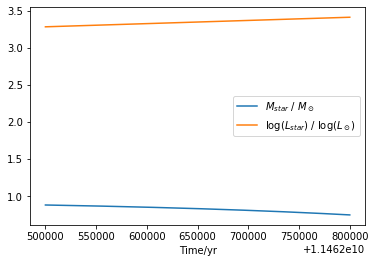

In [147]:
######################
# Get an array of times over which to do the analysis. User can define:
# - Nout:  number of measurements of the simulation
# - T0:    starting age of the star
# - t_tot: total time of integration for the system (M_star and L_star will start from T0) 
#
# This cell also plots those masses and luminosities.
######################

N_times = 10000
T0 = 1.14625e10
t_tot = 300000

ts = np.linspace(0, t_tot, N_times)
mtimes = masses(ts + T0)
lumins = lums_array(ts + T0)

plt.plot(ts + T0, mtimes)
plt.plot(ts + T0, lumins)
plt.legend([r"$M_{star}$ / $M_\odot$", r"log($L_{star}$) / log($L_\odot$)"])
plt.xlabel("Time/yr")
plt.show()

# Moon sim

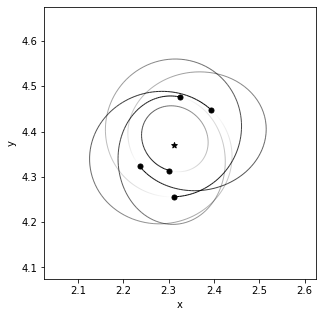

In [148]:
sim = rebound.Simulation()
sim.integrator = 'whfast'
rhill = 0.3543

irrgs_add = 5
moons_add = 0
num_hillies = 0

dt_w_inners = 0.008
dt_no_inner = 0.03

M0 = mtimes[0]

# Add Jupiter and satellites

sim.add(m=9.543e-4, x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='jupiter')
if (moons_add != 0):
    add_moons(sim, moons_add)
if (irrgs_add !=0):
    add_irregs(sim, irrgs_add)
if (num_hillies != 0):
    add_hillies(sim, num_hillies)

# Add Sun as Jupiter-centric; add saturn as solar-centric

sim.add(m=M0,primary=sim.particles['jupiter'], a=5.2, e=.04839, inc=-.022689, Omega=-1.8, omega=-.2574, hash='Sun')
#set simulation parameters

sim.move_to_com()

ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim(2.025,2.625)
ax.set_ylim(4.075,4.675)
fig.show()

In [149]:
num = irrgs_add

rad_ast = 10                                        # radius in km
moon_radii = np.full(num, rad_ast/1.496e+8)         # gives each asteroid a radius in AU

mass_typic = 3*(4/3)*np.pi*(rad_ast*100000)**3      # gives typical mass @ this radius, w/ density = 3 g cm^-3
moon_masses = np.random.normal(mass_typic, .3*mass_typic, num)        
                                                    # gives array of values around that mass
moon_masses /= 1.9891e33                            # divides each mass by M_sol to get masses in M_sol

print("Typical moon mass:", mass_typic, "g")
print("Average moon mass:", np.mean(moon_masses), "M_sol")

Typical moon mass: 1.2566370614359173e+19 g
Average moon mass: 6.929844529894723e-15 M_sol


In [150]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, times, mtimes, 'spline')
starlum = reboundx.Interpolator(rebx, times, lumins, 'spline')

rebx = reboundx.Extras(sim)
yrkv = rebx.create_force("yarkovsky")

yrkv.force_type = "vel"
yrkv.update_accelerations = yark
rebx.add_force(yrkv)

gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895

ps['jupiter'].params["J2"] = J2prime
ps['jupiter'].params["R_eq"] = R_jup

In [151]:
# initialize arrays for tracking progression of bodies over integration

x_sol = np.zeros(Nout); y_sol = np.zeros(Nout)
x_sol[0] = ps['Sun'].x
y_sol[0] = ps['Sun'].y

x_jup = np.zeros(Nout); y_jup = np.zeros(Nout)
x_jup[0] = ps['jupiter'].x
y_jup[0] = ps['jupiter'].y

m_sun = np.zeros(Nout)
a_jup = np.zeros(Nout)
e_jup = np.zeros(Nout) 
i_jup = np.zeros(Nout)
pmjup = np.zeros(Nout)
lmjup = np.zeros(Nout)

m_sun[0] = M0
a_jup[0] = ps['Sun'].a
e_jup[0] = ps['Sun'].e
i_jup[0] = ps['Sun'].inc
pmjup[0] = ps['Sun'].pomega
lmjup[0] = ps['Sun'].l

a_vals = np.zeros((num, Nout))
e_vals = np.zeros((num, Nout))
i_vals = np.zeros((num, Nout))
pmvals = np.zeros((num, Nout))
lmvals = np.zeros((num, Nout))
x_vals = np.zeros((num, Nout))
y_vals = np.zeros((num, Nout))

if (moons_add == 0):
    for moon in range(num):
        a_vals[moon,0] = ps[moon + 1].a
        e_vals[moon,0] = ps[moon + 1].e
        i_vals[moon,0] = ps[moon + 1].inc
        pmvals[moon,0] = ps[moon + 1].pomega
        lmvals[moon,0] = ps[moon + 1].l
        x_vals[moon,0] = ps[moon + 1].x
        y_vals[moon,0] = ps[moon + 1].y

else:
    for moon in range(num):
        a_vals[moon,0] = ps[moon + len(moons_add) + 1].a
        e_vals[moon,0] = ps[moon + len(moons_add) + 1].e
        i_vals[moon,0] = ps[moon + len(moons_add) + 1].inc
        pmvals[moon,0] = ps[moon + len(moons_add) + 1].pomega
        lmvals[moon,0] = ps[moon + len(moons_add) + 1].l
        x_vals[moon,0] = ps[moon + len(moons_add) + 1].x
        y_vals[moon,0] = ps[moon + len(moons_add) + 1].y

In [152]:
for i, time in enumerate(times):
    sim.integrate(time)
    
    ps['Sun'].m = starmass.interpolate(rebx, t=sim.t)
    sim.move_to_com()
    
    mass[i] = ps['Sun'].m
    x_sol[i] = ps['Sun'].x
    y_sol[i] = ps['Sun'].y
    x_jup[i] = ps['jupiter'].x
    y_jup[i] = ps['jupiter'].y  
    a_jup[i] = ps['Sun'].a
    e_jup[i] = ps['Sun'].e
    i_jup[i] = ps['Sun'].inc
    pmjup[i] = ps['Sun'].pomega
    lmjup[i] = ps['Sun'].l
    
    for moon in range(num):
        
        a_vals[moon, i] = ps[moon + 1].a
        e_vals[moon, i] = ps[moon + 1].e
        i_vals[moon, i] = ps[moon + 1].inc
        pmvals[moon, i] = ps[moon + 1].pomega
        lmvals[moon, i] = ps[moon + 1].l
        x_vals[moon, i] = ps[moon + 1].x
        y_vals[moon, i] = ps[moon + 1].y

KeyboardInterrupt: 

In [158]:
#fig, ax = rebound.OrbitPlot(sim)
#ax.set_xlim(2.025,2.625)
#ax.set_ylim(4.075,4.675)
#fig.show()


i_vals *= radeg
print(i_vals)

[[ 27.945       28.32331441  28.83852403 ...   0.           0.
    0.        ]
 [151.413      149.23205512 148.45671536 ...   0.           0.
    0.        ]
 [158.189      159.08025447 158.92174441 ...   0.           0.
    0.        ]
 [164.994      164.8560397  161.96171469 ...   0.           0.
    0.        ]
 [148.693      146.96448907 147.28277921 ...   0.           0.
    0.        ]]


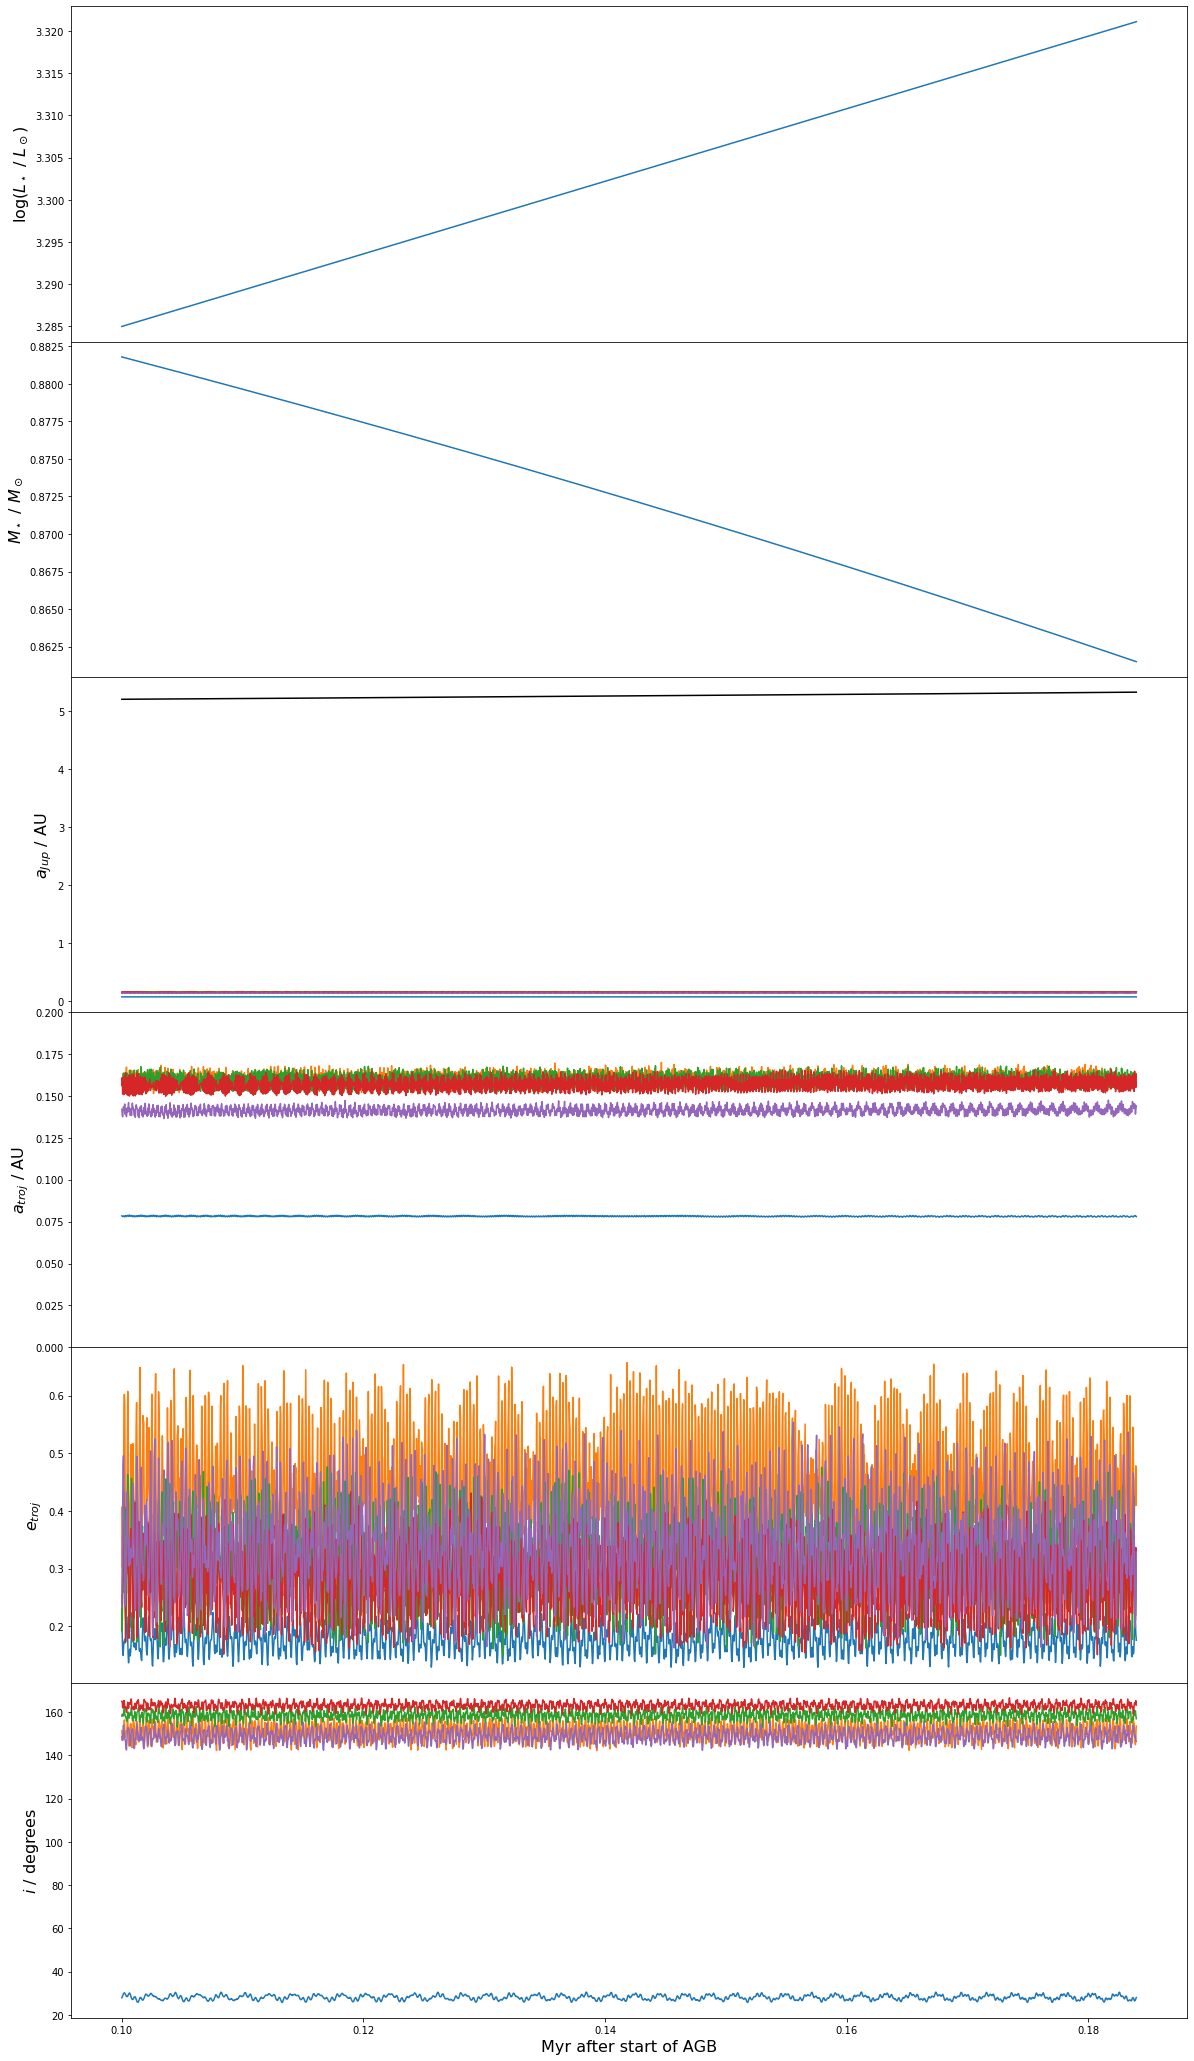

In [167]:
fig, ax = plt.subplots(6,1,figsize=(20,37), sharex=True)
plt.subplots_adjust(hspace=0)

end = 2400

ax[0].plot(ts[:end+400]/1e6+.1,lumins[:end+400])
ax[0].set_ylabel(r"log($L_\star$ / $L_\odot$)", fontsize=16)
ax[1].plot(times[:end]/1e6+.1,mass[:end])
ax[1].set_ylabel(r"$M_\star$ / $M_\odot$", fontsize=16)
ax[2].plot(times[:end]/1e6+.1, a_vals.T[:end,:])
ax[2].plot(times[:end]/1e6+.1, a_jup[:end], "k")
ax[2].set_ylabel(r"$a_{Jup}$ / AU", fontsize=16)
ax[3].plot(times[:end]/1e6+.1, a_vals.T[:end, :])
ax[3].plot(times[:end]/1e6+.1, a_jup[:end], "k")
ax[3].set_ylim(0,.2)
ax[3].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
ax[4].plot(times[:end]/1e6+.1, e_vals.T[:end,:])
ax[4].set_ylabel(r"$e_{troj}$", fontsize=16)
ax[5].plot(times[:end]/1e6+.1, i_vals.T[:end,:])
ax[5].set_ylabel(r"$i$ / degrees", fontsize=16)
ax[5].set_xlabel("Myr after start of AGB", fontsize=16)

fig.show()
#fig.savefig("irregs-all-elements.png", dpi=300)

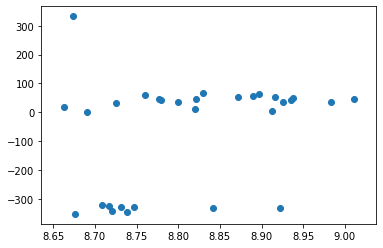

In [35]:
t_top = Nout - 1 #int(t_max - 1)

da = a_vals[:,t_top] - a_vals[:,0]
de = e_vals[:,t_top] - e_vals[:,0]
di = i_vals[:,t_top] - i_vals[:,0]
dw = Omvals[:,t_top] - Omvals[:,0]

plt.scatter(da, dw)
plt.show()

data = [de, de]

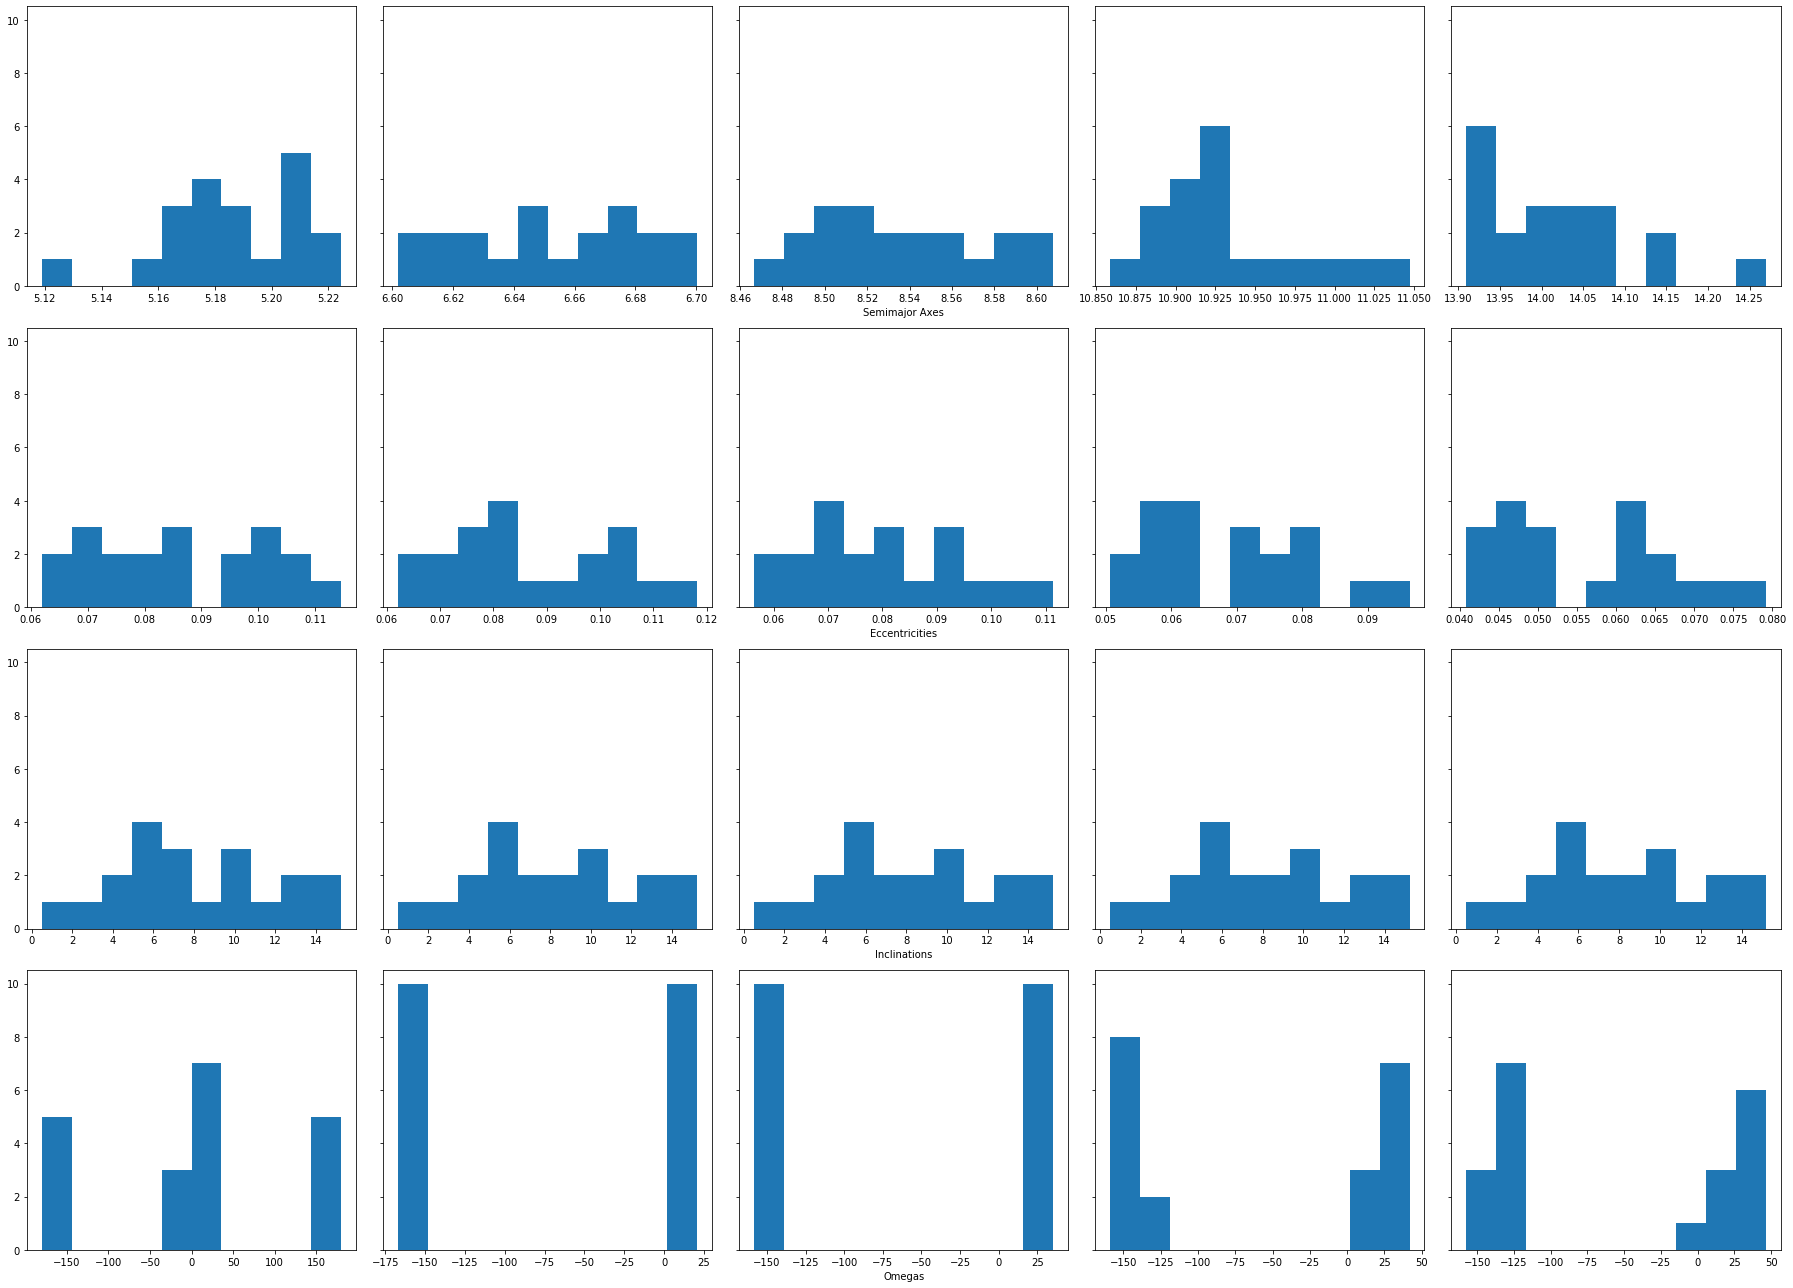

In [21]:
hists, hax = plt.subplots(4,5,figsize=(25,18), sharey=True)

(t1, t2, t3, t4) = (int(Nout/4 - 1), int(Nout/2 - 1), int(3*Nout/4 - 1), int(Nout - 1))

hax[0,0].hist(a_vals[:,0], 10)
hax[0,1].hist(a_vals[:,t1], 10)
hax[0,2].hist(a_vals[:,t2], 10)
hax[0,3].hist(a_vals[:,t3], 10)
hax[0,4].hist(a_vals[:,t4], 10)
hax[0,2].set_xlabel("Semimajor Axes")

hax[1,0].hist(e_vals[:,0], 10)
hax[1,1].hist(e_vals[:,t1], 10)
hax[1,2].hist(e_vals[:,t2], 10)
hax[1,3].hist(e_vals[:,t3], 10)
hax[1,4].hist(e_vals[:,t4], 10)
hax[1,2].set_xlabel("Eccentricities")

hax[2,0].hist(i_vals[:,0], 10)
hax[2,1].hist(i_vals[:,t1], 10)
hax[2,2].hist(i_vals[:,t2], 10)
hax[2,3].hist(i_vals[:,t3], 10)
hax[2,4].hist(i_vals[:,t4], 10)
hax[2,2].set_xlabel("Inclinations")

hax[3,0].hist(Omvals[:,0], 10)
hax[3,1].hist(Omvals[:,t1], 10)
hax[3,2].hist(Omvals[:,t2], 10)
hax[3,3].hist(Omvals[:,t3], 10)
hax[3,4].hist(Omvals[:,t4], 10)
hax[3,2].set_xlabel("Omegas")

hists.tight_layout()